In [708]:
import os
import sys
import datetime
import time

import pandas as pd
import numpy as np
from math import radians, sin, cos, acos
import json
import scipy
from statsmodels.tsa.arima_model import ARIMA

import sqlite3

%matplotlib inline
from matplotlib import patheffects
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [561]:
df_30m_nationalconsumption=pd.read_csv("../../data/30m_national_consumption.csv.gz")
df_30m_nationalconsumption["tstp"]=pd.to_datetime(df_30m_nationalconsumption["tstp"])
df_30m_nationalconsumption.head()

,tstp,consumption,quality
0,2008-07-06 10:00:00,44486,Definitive
1,2008-07-06 11:00:00,46270,Definitive
2,2008-07-06 11:30:00,44801,Definitive
3,2008-07-06 13:00:00,41919,Definitive
4,2008-07-06 14:30:00,40135,Definitive


In [562]:
df_30m_nationalconsumption_definitive=df_30m_nationalconsumption[df_30m_nationalconsumption["quality"]=="Definitive"]
df_30m_nationalconsumption_definitive["energy"]=df_30m_nationalconsumption_definitive.apply(lambda row: row["consumption"]*30*60/3600,axis=1)
df_30m_nationalconsumption_definitive["day"]=df_30m_nationalconsumption_definitive.apply(lambda row: row["tstp"].strftime("%Y-%m-%d"),axis=1)
df_30m_nationalconsumption_definitive["month"]=df_30m_nationalconsumption_definitive.apply(lambda row: int(row["tstp"].strftime("%m")),axis=1)
df_30m_nationalconsumption_definitive["weekday"]=df_30m_nationalconsumption_definitive.apply(lambda row: row["tstp"].weekday(),axis=1)
df_30m_nationalconsumption_definitive["halfhour"]=df_30m_nationalconsumption_definitive.apply(lambda row: int(row["tstp"].strftime("%H"))+int(row["tstp"].strftime("%M"))/30,axis=1)
df_30m_nationalconsumption_definitive=df_30m_nationalconsumption_definitive.set_index(["tstp"])
df_30m_nationalconsumption_definitive.describe()

C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,consumption,energy,month,weekday,halfhour
count,140254.000000,140254.000000,140254.000000,140254.000000,140254.000000
mean,55285.652744,27642.826372,6.522053,2.998973,11.999950
std,12169.274144,6084.637072,3.448683,1.999422,6.939978
min,29477.000000,14738.500000,1.000000,0.000000,0.000000
25%,46009.000000,23004.500000,4.000000,1.000000,6.000000
50%,53729.000000,26864.500000,7.000000,3.000000,12.000000
75%,63594.750000,31797.375000,10.000000,5.000000,18.000000
max,101866.000000,50933.000000,12.000000,6.000000,24.000000


In [347]:
aggregations={
    "energy":"sum",
    "month":"first",
    "weekday":"first"
}




df_daily_energy_consumption=df_30m_nationalconsumption_definitive.groupby(["day"]).agg(aggregations)
df_daily_energy_consumption.head()

,energy,month,weekday
day,,,
2008-01-01,1465179.0,1,1
2008-01-02,1737852.0,1,2
2008-01-03,1792039.0,1,3
2008-01-04,1713511.5,1,4
2008-01-05,1526082.0,1,5


In [348]:
list_df=[]
df_weather=pd.read_csv("../../data/weather_data.csv.gz")
df_weather["tstp"]=pd.to_datetime(df_weather["tstp"])
df_weather["wind_speed"]=pd.to_numeric(df_weather["wind_speed"],errors="coerce")
df_weather=df_weather[(df_weather["wind_speed"]<200) & (df_weather["wind_speed"]>0)]
df_weather=df_weather[(df_weather["outdoor_temperature"]>-20) & (df_weather["outdoor_temperature"]<50)]
df_weather=df_weather[(df_weather["outdoor_humidity"]>0) & (df_weather["outdoor_humidity"]<100)]

df_weather=df_weather[["tstp","outdoor_temperature","outdoor_humidity","wind_speed"]].set_index(["tstp"])
for param in ["outdoor_temperature","outdoor_humidity","wind_speed"]:
    print(param)
    list_df.append(df_weather[[param]].resample('30T').interpolate(method='linear'))
df_weather_cf=pd.concat(list_df,axis=1).reset_index()
df_weather_cf.head()

outdoor_temperature
outdoor_humidity
wind_speed


,tstp,outdoor_temperature,outdoor_humidity,wind_speed
0,2006-01-01 00:00:00,6.000000,54.0,22.200000
1,2006-01-01 00:30:00,5.833333,58.5,19.116667
2,2006-01-01 01:00:00,5.666667,63.0,16.033333
3,2006-01-01 01:30:00,5.500000,67.5,12.950000
4,2006-01-01 02:00:00,5.333333,72.0,9.866667


In [349]:
df_weather_cf["day"]=df_weather_cf.apply(lambda row:row["tstp"].strftime("%Y-%m-%d"),axis=1)

In [350]:
df_daily_weather_cf=df_weather_cf.groupby(["day"]).mean()
df_daily_weather_cf.head()

,outdoor_temperature,outdoor_humidity,wind_speed
day,,,
2006-01-01,5.458333,73.187500,11.767708
2006-01-02,3.927083,81.135417,13.622917
2006-01-03,3.156250,78.916667,11.147917
2006-01-04,0.510417,85.895833,7.448958
2006-01-05,-1.285417,88.979167,3.532917


In [351]:
df_weather_national=pd.read_csv("../../data/weathernational_data.csv.gz")
df_weather_national["tstp"]=pd.to_datetime(df_weather_national["tstp"])
df_weather_national["day"]=df_weather_national.apply(lambda row:row["tstp"].strftime("%Y-%m-%d"),axis=1)
df_weather_national=df_weather_national.set_index(["tstp"])
df_weather_national.head()

,outdoor_humidity,outdoor_temperature,wind_speed,day
tstp,,,,
2007-06-06 14:30:00,62.555688,22.965797,17.073516,2007-06-06
2007-06-06 15:00:00,63.815123,22.869189,17.166643,2007-06-06
2007-06-06 15:30:00,64.946597,22.470817,17.159937,2007-06-06
2007-06-06 16:00:00,67.336973,22.186515,16.841663,2007-06-06
2007-06-06 16:30:00,67.237105,22.166204,16.926711,2007-06-06


In [352]:
df_daily_weather_national=df_weather_national.groupby(["day"]).mean()
df_daily_weather_national.head()

,outdoor_humidity,outdoor_temperature,wind_speed
day,,,
2007-06-06,77.006787,19.645566,14.665435
2007-06-07,81.704915,19.045708,11.425905
2007-06-08,81.117675,19.788427,8.937123
2007-06-09,76.699413,20.553861,8.698643
2007-06-10,77.624361,20.274004,9.872836


# Benchmark model

In [354]:
df_ptg=df_daily_weather_cf.join(df_daily_energy_consumption,how='inner')[["outdoor_temperature","outdoor_humidity","wind_speed","energy","month","weekday"]]
df_ptg.head()

,outdoor_temperature,outdoor_humidity,wind_speed,energy,month,weekday
day,,,,,,
2008-01-01,0.381944,87.062500,6.418056,1465179.0,1,1
2008-01-02,-0.850694,89.104167,4.695486,1737852.0,1,2
2008-01-03,7.114583,70.041667,22.554167,1792039.0,1,3
2008-01-04,7.947917,74.208333,15.127083,1713511.5,1,4
2008-01-05,9.854167,70.916667,26.614583,1526082.0,1,5


In [340]:
def ptg_model(x, a, b, x0):
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: a*x+b , lambda x:a*x0+b])

def get_model_ptg(x,y):
    x0_min = 0
    x0_max = 20
    a_min=-200000
    a_max=-50000
    b_min=1000000
    b_max=3000000
    bounds_min = [a_min, b_min, x0_min]
    bounds_max = [a_max, b_max, x0_max]
    bounds = (bounds_min, bounds_max)
    popt, pcov = scipy.optimize.curve_fit(ptg_model, x, y, bounds=bounds)
    a= popt[0]
    b = popt[1]
    x0 = popt[2]
    return a,b,x0

In [341]:
model=get_model_ptg(list(df_ptg["outdoor_temperature"]),list(df_ptg["energy"]))
new_x = np.linspace(df_ptg["outdoor_temperature"].min(), df_ptg["outdoor_temperature"].max(), 100)

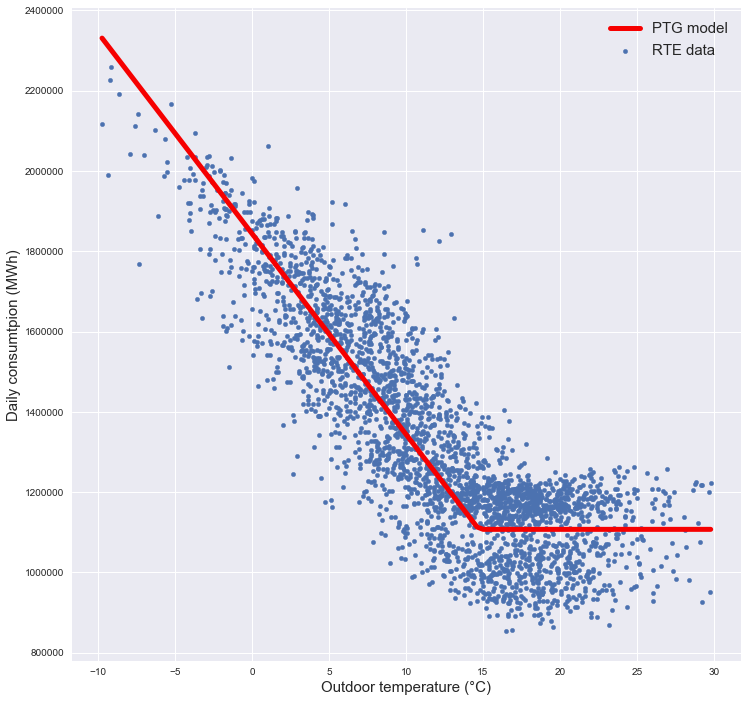

In [342]:
fig, ax = plt.subplots(figsize=(12,12))
df_ptg.plot(ax=ax,x="outdoor_temperature",y="energy",kind="scatter",label="RTE data")
ax.plot(new_x,ptg_model(new_x, model[0], model[1], model[2]),color="#F60000",linewidth=5.0,label="PTG model");
ax.set_xlabel("Outdoor temperature (°C)", fontsize=15)
ax.set_ylabel("Daily consumtpion (MWh)", fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

ax.figure.savefig("../../reports/pictures/ptg.png")

In [643]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import explained_variance_score, r2_score,mean_absolute_error
from sklearn.model_selection import KFold




df_totest=df_ptg.copy()

df_totest.head()

df_split=df_totest.copy()
for param in ['outdoor_temperature','outdoor_humidity','wind_speed','month','weekday']:
    df_split[param]=df_split.apply(lambda row: (row[param]-df_split[param].mean())/(df_split[param].max()-df_split[param].min()),axis=1)
print(df_split.head())


# # # Make linear regression
# X_train, X_test, y_train, y_test = train_test_split(df[['outdoor_temperature','weekday','month']],df["energy"],test_size=0.2,random_state=42)
# print("Training samples",len(X_train))
# print("Test samples",len(X_test))


X_train, X_test, y_train, y_test = train_test_split(np.array(df_split["outdoor_temperature"]),np.array(df_split["energy"]),test_size=0.2,random_state=42)

print("Number of elements for the training set: {} samples".format(len(X_train)))
print("Number of elements for the testing set: {} samples".format(len(X_test)))

            outdoor_temperature  outdoor_humidity  wind_speed     energy  \
day                                                                        
2008-01-01            -0.294075          0.257554   -0.093683  1465179.0   
2008-01-02            -0.325253          0.286615   -0.139328  1737852.0   
2008-01-03            -0.123786          0.015283    0.333899  1792039.0   
2008-01-04            -0.102708          0.074590    0.137093  1713511.5   
2008-01-05            -0.054493          0.027737    0.441493  1526082.0   

               month   weekday  
day                             
2008-01-01 -0.502085 -0.333162  
2008-01-02 -0.502085 -0.166496  
2008-01-03 -0.502085  0.000171  
2008-01-04 -0.502085  0.166838  
2008-01-05 -0.502085  0.333504  
Number of elements for the training set: 2337 samples
Number of elements for the testing set: 585 samples


In [468]:
# For the normalise version fo the tmeperature
def get_model_ptg(x,y):
    x0_min = -1
    x0_max = 1
    a_min=-2000000
    a_max=-500000
    b_min=1000000
    b_max=3000000
    bounds_min = [a_min, b_min, x0_min]
    bounds_max = [a_max, b_max, x0_max]
    bounds = (bounds_min, bounds_max)
    popt, pcov = scipy.optimize.curve_fit(ptg_model, x, y, bounds=bounds)
    a= popt[0]
    b = popt[1]
    x0 = popt[2]
    return a,b,x0

In [469]:
kf = KFold(n_splits=10)

In [644]:
def get_bestptgmodel(X_train, X_test, y_train, y_test,kf):
    r2score_ref=-1*np.inf
    executiontime_ref=0
    best_model={}
    for train_index, validation_index in kf.split(X_train):
        tic=time.time()
        X_training, X_validation = X_train[train_index], X_train[validation_index]
        y_training, y_validation = y_train[train_index], y_train[validation_index]

        model=get_model_ptg(X_training,y_training)
        toc=time.time()-tic
        y_pred=[]
        for value in X_validation:
            y_pred.append(ptg_model(value,model[0],model[1],model[2]))

        print(r2_score(y_validation, y_pred),mean_absolute_error(y_validation, y_pred))

        score=r2_score(y_validation, y_pred)
        if score>r2score_ref:
            r2score_ref=score
            executiontime_ref=toc
            best_model=model
            print("Best model:",r2score_ref,toc)

    
    # Test the best model in the testing set
    y_pred=[]
    for value in X_test:
        y_pred.append(ptg_model(value,best_model[0],best_model[1],best_model[2]))
        
    r2score_test=r2_score(y_test, y_pred)
    meanabserror_test= mean_absolute_error(y_test, y_pred)
    print("Final results:",r2score_test,meanabserror_test,executiontime_ref)  
    return best_model,r2score_test,meanabserror_test,executiontime_ref

In [645]:
result_ptg=get_bestptgmodel(X_train, X_test, y_train, y_test,kf)
result_ptg

0.740640875186 107942.535854
Best model: 0.740640875186 0.021054744720458984
0.810774499038 89485.2650779
Best model: 0.810774499038 0.01804947853088379
0.779147985077 102946.955896
0.75140516864 109253.245419
0.790185578769 97407.2865621
0.734879341835 109850.231107
0.744385885379 106014.496339
0.797271872527 92608.137232
0.755251368455 110309.464863
0.789394320048 105923.627992
Final results: 0.770627227729 103931.113259 0.01804947853088379


((-1670422.7726314215, 1278752.0762531692, 0.10732184260065994),
 0.77062722772867165,
 103931.11325900865,
 0.01804947853088379)

**Notes** : This the benchmark model for the analysis

## Find the right new models

### Test the polynomial regression

In [650]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import clone


def get_bestpolynomialmodel(X_train, X_test, y_train, y_test,kf,degree):
    r2score_ref=-1*np.inf
    executiontime_ref=0
    best_model={}
    for train_index, validation_index in kf.split(X_train):
        tic=time.time()
        X_training, X_validation = X_train[train_index], X_train[validation_index]
        y_training, y_validation = y_train[train_index], y_train[validation_index]
        
        model = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(X_training, y_training)
        
        toc=time.time()-tic
        
        y_pred=model.predict(X_validation)
        
        print(r2_score(y_validation, y_pred),mean_absolute_error(y_validation, y_pred))

        score=r2_score(y_validation, y_pred)
        if score>r2score_ref:
            r2score_ref=score
            executiontime_ref=toc
            best_model=model
            print("Best model:",r2score_ref,toc)



    y_pred=best_model.predict(X_test)
    r2score_test=r2_score(y_test, y_pred)
    meanabserror_test= mean_absolute_error(y_test, y_pred)
    print("Final results:",r2score_test,meanabserror_test,executiontime_ref)  
    return best_model,r2score_test,meanabserror_test,executiontime_ref

In [651]:
list_results=[]
r2score_ref=-1*np.inf
for degree in range(0,16):
    print(r2score_ref)
    print("DEGREE:",degree)
    results_poly=get_bestpolynomialmodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train.reshape(-1, 1), y_test.reshape(-1, 1),kf,degree)
    list_results.append(["PR:{}".format(degree),results_poly[1],results_poly[2],results_poly[3]])
    if results_poly[1]>r2score_ref:
        print(degree)
        r2score_ref=results_poly[1]
        ref_model=results_poly
print('-------------FINAL_BM-------------',ref_model)
df_resultspoly=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultspoly.head())
df_resultspoly.to_csv("../../results/RAW_dailyconsumption_poly.csv",index=False)

-inf
DEGREE: 0
-2.38823109733e-07 221101.137399
Best model: -2.38823109733e-07 0.0025169849395751953
-0.0011982840214 215059.855454
-0.000106398694854 224936.010079
-0.00258518511472 229442.620716
-0.00822777998963 226378.445673
-0.000319388134704 222405.509123
-0.00380003709019 219990.726164
-0.00121936406602 220105.479208
-0.00148419525346 234846.870645
-0.000336945595913 237432.164819
Final results: -0.000277266999369 223059.969218 0.0025169849395751953
0
-0.000277266999369
DEGREE: 1
0.671647925316 121584.84241
Best model: 0.671647925316 0.001990795135498047
0.725283168538 109569.392485
Best model: 0.725283168538 0.0020058155059814453
0.729582585948 111486.135517
Best model: 0.729582585948 0.0010025501251220703
0.678198767835 122858.497122
0.723206438222 113719.403083
0.684450710307 118348.523206
0.676964528536 121425.252829
0.734889577977 107474.081948
Best model: 0.734889577977 0.0010020732879638672
0.669774560556 127986.058396
0.738062885908 117579.284719
Best model: 0.7380628859

### Random forest regressor

In [652]:
from sklearn.ensemble import RandomForestRegressor

def get_bestrandomforestmodel(X_train, X_test, y_train, y_test,kf,max_depth):
    r2score_ref=-1*np.inf
    executiontime_ref=0
    best_model={}
    for train_index, validation_index in kf.split(X_train):
        tic=time.time()
        X_training, X_validation = X_train[train_index], X_train[validation_index]
        y_training, y_validation = y_train[train_index], y_train[validation_index]
        
        model= RandomForestRegressor(max_depth=max_depth, random_state=0)
        model.fit(X_training, y_training)
        
        toc=time.time()-tic
        
        y_pred=model.predict(X_validation)
        
#         print(r2_score(y_validation, y_pred),mean_absolute_error(y_validation, y_pred))

        score=r2_score(y_validation, y_pred)
        if score>r2score_ref:
            r2score_ref=score
            executiontime_ref=toc
            best_model=model
#             print("Best model:",r2score_ref,toc)



    y_pred=best_model.predict(X_test)
    r2score_test=r2_score(y_test, y_pred)
    meanabserror_test= mean_absolute_error(y_test, y_pred)
    print("Final results:",r2score_test,meanabserror_test,executiontime_ref)  
    return best_model,r2score_test,meanabserror_test,executiontime_ref

In [655]:
list_results=[]
r2score_ref=-1*np.inf
for max_depth in range(2,15):
    print("MAX_DEPTH:",max_depth)
    results_randomforest=get_bestrandomforestmodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,max_depth)
    list_results.append(["RF:{}".format(max_depth),results_randomforest[1],results_randomforest[2],results_randomforest[3]])
    if results_randomforest[1]>r2score_ref:
        print(degree)
        r2score_ref=results_randomforest[1]
        ref_model=results_randomforest
print('-------------FINAL_BM-------------',ref_model)    
df_resultsrandomforest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsrandomforest.head())
df_resultsrandomforest.to_csv("../../results/RAW_dailyconsumption_randomforest.csv",index=False)

MAX_DEPTH: 2
Final results: 0.7472615004 108781.903682 0.01405477523803711
15
MAX_DEPTH: 3
Final results: 0.766777105085 105124.735437 0.01153111457824707
15
MAX_DEPTH: 4
Final results: 0.768864462878 104500.324376 0.014036417007446289
15
MAX_DEPTH: 5
Final results: 0.76573471656 105304.901646 0.015597820281982422
MAX_DEPTH: 6
Final results: 0.760363398543 106591.665701 0.015626192092895508
MAX_DEPTH: 7
Final results: 0.753032267458 108273.017218 0.015627384185791016
MAX_DEPTH: 8
Final results: 0.745756126065 109722.967097 0.01566171646118164
MAX_DEPTH: 9
Final results: 0.733701748712 112260.030668 0.024431228637695312
MAX_DEPTH: 10
Final results: 0.722829606504 113064.548096 0.018047332763671875
MAX_DEPTH: 11
Final results: 0.710270126753 115494.049404 0.02208566665649414
MAX_DEPTH: 12
Final results: 0.706594293825 116218.89235 0.0240631103515625
MAX_DEPTH: 13
Final results: 0.685869411424 120027.546809 0.024062395095825195
MAX_DEPTH: 14
Final results: 0.678777207599 120585.70869 0.02

### Decision tree regressor

In [656]:
from sklearn.tree import DecisionTreeRegressor

def get_bestdecisiontreemodel(X_train, X_test, y_train, y_test,kf,max_depth):
    r2score_ref=-1*np.inf
    executiontime_ref=0
    best_model={}
    for train_index, validation_index in kf.split(X_train):
        tic=time.time()
        X_training, X_validation = X_train[train_index], X_train[validation_index]
        y_training, y_validation = y_train[train_index], y_train[validation_index]
        
        model= DecisionTreeRegressor(max_depth=max_depth, random_state=0)
        model.fit(X_training, y_training)
        
        toc=time.time()-tic
        
        y_pred=model.predict(X_validation)
        
#         print(r2_score(y_validation, y_pred),mean_absolute_error(y_validation, y_pred))

        score=r2_score(y_validation, y_pred)
        if score>r2score_ref:
            r2score_ref=score
            executiontime_ref=toc
            best_model=model
#             print("Best model:",r2score_ref,toc)



    y_pred=best_model.predict(X_test)
    r2score_test=r2_score(y_test, y_pred)
    meanabserror_test= mean_absolute_error(y_test, y_pred)
    print("Final results:",r2score_test,meanabserror_test,executiontime_ref)  
    return best_model,r2score_test,meanabserror_test,executiontime_ref

In [658]:
list_results=[]
r2score_ref=-1*np.inf
for max_depth in range(2,16):
    print("MAX_DEPTH:",max_depth)
    results_tdecisiontree=get_bestdecisiontreemodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,max_depth)
    list_results.append(["DT:{}".format(max_depth),results_tdecisiontree[1],results_tdecisiontree[2],results_tdecisiontree[3]])
    if results_tdecisiontree[1]>r2score_ref:
        r2score_ref=results_tdecisiontree[1]
        ref_model=results_tdecisiontree
print('-------------FINAL_BM-------------',ref_model)        
df_resultsdecisiontree=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsdecisiontree.head())
df_resultsdecisiontree.to_csv("../../results/RAW_dailyconsumption_decisiontree.csv",index=False)

MAX_DEPTH: 2
Final results: 0.721268085411 112554.648556 0.001003265380859375
MAX_DEPTH: 3
Final results: 0.759756245115 105876.274479 0.001003265380859375
MAX_DEPTH: 4
Final results: 0.766962274127 105140.431253 0.002004384994506836
MAX_DEPTH: 5
Final results: 0.765677881998 105271.085695 0.0010023117065429688
MAX_DEPTH: 6
Final results: 0.752931619624 108286.118669 0.0010018348693847656
MAX_DEPTH: 7
Final results: 0.740598592035 110027.753477 0.0025055408477783203
MAX_DEPTH: 8
Final results: 0.727730370128 113297.177033 0.0
MAX_DEPTH: 9
Final results: 0.711444456602 114928.864271 0.0
MAX_DEPTH: 10
Final results: 0.700738755996 116494.18802 0.0
MAX_DEPTH: 11
Final results: 0.679240614756 120256.206133 0.0
MAX_DEPTH: 12
Final results: 0.672549070729 121764.621377 0.002009868621826172
MAX_DEPTH: 13
Final results: 0.655949504403 124924.945645 0.0030069351196289062
MAX_DEPTH: 14
Final results: 0.646005561697 126137.849993 0.004040718078613281
MAX_DEPTH: 15
Final results: 0.642339306879 12

### K-nearest neighbor approach

In [659]:
from sklearn.neighbors import KNeighborsRegressor

def get_bestknearestmodel(X_train, X_test, y_train, y_test,kf,param_model):
    r2score_ref=-1*np.inf
    executiontime_ref=0
    best_model={}
    for train_index, validation_index in kf.split(X_train):
        tic=time.time()
        X_training, X_validation = X_train[train_index], X_train[validation_index]
        y_training, y_validation = y_train[train_index], y_train[validation_index]
        
        model=KNeighborsRegressor(param_model[0], weights=param_model[1])
        model.fit(X_training, y_training)
        
        toc=time.time()-tic
        
        y_pred=model.predict(X_validation)
        
#         print(r2_score(y_validation, y_pred),mean_absolute_error(y_validation, y_pred))

        score=r2_score(y_validation, y_pred)
        if score>r2score_ref:
            r2score_ref=score
            executiontime_ref=toc
            best_model=model
#             print("Best model:",r2score_ref,toc)



    y_pred=best_model.predict(X_test)
    r2score_test=r2_score(y_test, y_pred)
    meanabserror_test= mean_absolute_error(y_test, y_pred)
#     print("Final results:",r2score_test,meanabserror_test,executiontime_ref)  
    return best_model,r2score_test,meanabserror_test,executiontime_ref


In [661]:
list_results=[]
r2score_ref=-1*np.inf
for neighbors in range(1,30):
    print("NUMBER OF NEIGHBORS:",neighbors)
    for weights in ['uniform','distance']:
        print("WEIGHTS",weights)
        results_knearest=get_bestknearestmodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,[neighbors,weights])
        list_results.append(["KNN:{}/{}".format(neighbors,weights),results_knearest[1],results_knearest[2],results_knearest[3]])
        if results_knearest[1]>r2score_ref:
            r2score_ref=results_knearest[1]
            ref_model=results_knearest
print('-------------FINAL_BM-------------',ref_model) 
df_resultsknearest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsknearest.head())
df_resultsknearest.to_csv("../../results/RAW_dailyconsumption_knearest.csv",index=False)

NUMBER OF NEIGHBORS: 1
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 2
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 3
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 4
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 5
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 6
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 7
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 8
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 9
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 10
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 11
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 12
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 13
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 14
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 15
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 16
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 17
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 18
WEIGHTS uniform


### Neural network mlp regrressor

In [662]:
from sklearn.neural_network import MLPRegressor
model=MLPRegressor(max_iter=1000)
def get_bestmlp(X_train, X_test, y_train, y_test,kf,param_model):
    r2score_ref=-1*np.inf
    executiontime_ref=0
    best_model={}
    for train_index, validation_index in kf.split(X_train):
        tic=time.time()
        X_training, X_validation = X_train[train_index], X_train[validation_index]
        y_training, y_validation = y_train[train_index], y_train[validation_index]
        
        model=MLPRegressor(hidden_layer_sizes=param_model[0],activation=param_model[1],solver=param_model[2],random_state=0)
        model.fit(X_training, y_training)
        
        toc=time.time()-tic
        
        y_pred=model.predict(X_validation)
        
#         print(r2_score(y_validation, y_pred),mean_absolute_error(y_validation, y_pred))

        score=r2_score(y_validation, y_pred)
        if score>r2score_ref:
            r2score_ref=score
            executiontime_ref=toc
            best_model=model
#             print("Best model:",r2score_ref,toc)



    y_pred=best_model.predict(X_test)
    r2score_test=r2_score(y_test, y_pred)
    meanabserror_test= mean_absolute_error(y_test, y_pred)
    print("Final results:",r2score_test,meanabserror_test,executiontime_ref)  
    return best_model,r2score_test,meanabserror_test,executiontime_ref

In [664]:
# Try the find the right parameters
list_results=[]
r2score_ref=-1*np.inf
for hidden_layers in [2,4,8,16,32,64,128,256]:
    for activation in ["identity","logistic","tanh","relu"]:
        for solver in ["lbfgs","adam"]:
            print(hidden_layers,activation,solver)
            results_mlp=get_bestmlp(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,[hidden_layers,activation,solver])
            list_results.append(["NN_MLP:{}/{}/{}".format(hidden_layers,activation,solver),results_mlp[1],results_mlp[2],results_mlp[3]])
            if results_mlp[1]>r2score_ref:
                r2score_ref=results_mlp[1]
                ref_model=results_mlp
print('-------------FINAL_BM-------------',ref_model) 
df_resultsmlp=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsmlp.head())

2 identity lbfgs
Final results: 0.695703201667 117750.171827 0.0070188045501708984
2 identity adam


C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Final results: -24.9375599928 1323274.46897 0.47977781295776367
2 logistic lbfgs
Final results: -0.00027726692792 223059.969114 0.01303553581237793
2 logistic adam
Final results: -24.9381852404 1323290.60572 0.55096435546875
2 tanh lbfgs
Final results: -0.00027726697914 223059.969189 0.010528087615966797
2 tanh adam
Final results: -24.9381541016 1323289.77486 0.5098714828491211
2 relu lbfgs
Final results: 0.695703201388 117750.172991 0.012533426284790039
2 relu adam
Final results: -24.9375587913 1323274.43295 0.5010116100311279
4 identity lbfgs
Final results: 0.695703203965 117750.172774 0.0
4 identity adam
Final results: -24.9367106654 1323252.50521 0.47275590896606445
4 logistic lbfgs
Final results: -0.00027726699937 223059.969218 0.020554780960083008
4 logistic adam
Final results: -24.9379829396 1323285.25224 0.4993278980255127
4 tanh lbfgs
Final results: -0.000277266999164 223059.969218 0.012533187866210938
4 tanh adam
Final results: -24.9379159086 1323283.46437 0.5123615264892578


# Test new features with the models

In [688]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df_split[["outdoor_temperature","weekday","month"]]),np.array(df_split["energy"]),test_size=0.2,random_state=42)

print("Number of elements for the training set: {} samples".format(len(X_train)))
print("Number of elements for the testing set: {} samples".format(len(X_test)))

Number of elements for the training set: 2337 samples
Number of elements for the testing set: 585 samples


In [689]:
list_results=[]
r2score_ref=-1*np.inf
for degree in range(0,16):
    print(r2score_ref)
    print("DEGREE:",degree)
    results_poly=get_bestpolynomialmodel(X_train, X_test, y_train.reshape(-1, 1), y_test.reshape(-1, 1),kf,degree)
    list_results.append(["PR:{}".format(degree),results_poly[1],results_poly[2],results_poly[3]])
    if results_poly[1]>r2score_ref:
        print(degree)
        r2score_ref=results_poly[1]
        ref_model=results_poly
print('-------------FINAL_BM-------------',ref_model)
df_resultspoly=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultspoly.head())

-inf
DEGREE: 0
-2.38823109733e-07 221101.137399
Best model: -2.38823109733e-07 0.002008199691772461
-0.0011982840214 215059.855454
-0.000106398694854 224936.010079
-0.00258518511472 229442.620716
-0.00822777998963 226378.445673
-0.000319388134704 222405.509123
-0.00380003709019 219990.726164
-0.00121936406602 220105.479208
-0.00148419525346 234846.870645
-0.000336945595913 237432.164819
Final results: -0.000277266999369 223059.969218 0.002008199691772461
0
-0.000277266999369
DEGREE: 1
0.796146622932 94695.9245469
Best model: 0.796146622932 0.0030078887939453125
0.801894068628 94854.4983452
Best model: 0.801894068628 0.002004384994506836
0.812102692079 93995.3664902
Best model: 0.812102692079 0.0020055770874023438
0.814990337704 93407.9550528
Best model: 0.814990337704 0.0010023117065429688
0.826252375632 86833.2872841
Best model: 0.826252375632 0.0020058155059814453
0.808903328304 89255.0260908
0.79451628196 95553.6243701
0.835651253556 85703.5603323
Best model: 0.835651253556 0.002005

### Randon forest model

In [690]:
list_results=[]
r2score_ref=-1*np.inf
for max_depth in range(2,15):
    print("MAX_DEPTH:",max_depth)
    results_randomforest=get_bestrandomforestmodel(X_train, X_test, y_train, y_test,kf,max_depth)
    list_results.append(["RF:{}".format(max_depth),results_randomforest[1],results_randomforest[2],results_randomforest[3]])
    if results_randomforest[1]>r2score_ref:
        print(degree)
        r2score_ref=results_randomforest[1]
        ref_model=results_randomforest
print('-------------FINAL_BM-------------',ref_model)    
df_resultsrandomforest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsrandomforest.head())

MAX_DEPTH: 2
Final results: 0.838441992812 82401.7222091 0.014034271240234375
15
MAX_DEPTH: 3
Final results: 0.88824334357 67071.1073075 0.01562666893005371
15
MAX_DEPTH: 4
Final results: 0.910517527179 59200.8138842 0.015621185302734375
15
MAX_DEPTH: 5
Final results: 0.925647647944 52970.2759261 0.015627384185791016
15
MAX_DEPTH: 6
Final results: 0.93417891487 48972.4850192 0.01562666893005371
15
MAX_DEPTH: 7
Final results: 0.936444173754 47761.2844801 0.015626907348632812
15
MAX_DEPTH: 8
Final results: 0.934875147943 48072.1992594 0.024063825607299805
MAX_DEPTH: 9
Final results: 0.933482783935 48585.3528884 0.027082443237304688
MAX_DEPTH: 10
Final results: 0.933062094253 48980.3216672 0.028106689453125
MAX_DEPTH: 11
Final results: 0.931692493199 49617.451693 0.02626776695251465
MAX_DEPTH: 12
Final results: 0.929068224212 50976.74738 0.021813154220581055
MAX_DEPTH: 13
Final results: 0.929179287592 51178.4575015 0.03125452995300293
MAX_DEPTH: 14
Final results: 0.928862652275 51193.0015

### Random forest model

In [691]:
list_results=[]
r2score_ref=-1*np.inf
for max_depth in range(2,15):
    print("MAX_DEPTH:",max_depth)
    results_randomforest=get_bestrandomforestmodel(X_train, X_test, y_train, y_test,kf,max_depth)
    list_results.append(["RF:{}".format(max_depth),results_randomforest[1],results_randomforest[2],results_randomforest[3]])
    if results_randomforest[1]>r2score_ref:
        print(degree)
        r2score_ref=results_randomforest[1]
        ref_model=results_randomforest
print('-------------FINAL_BM-------------',ref_model)    
df_resultsrandomforest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsrandomforest.head())

MAX_DEPTH: 2
Final results: 0.838441992812 82401.7222091 0.015628814697265625
15
MAX_DEPTH: 3
Final results: 0.88824334357 67071.1073075 0.0
15
MAX_DEPTH: 4
Final results: 0.910517527179 59200.8138842 0.01562643051147461
15
MAX_DEPTH: 5
Final results: 0.925647647944 52970.2759261 0.01563096046447754
15
MAX_DEPTH: 6
Final results: 0.93417891487 48972.4850192 0.015628337860107422
15
MAX_DEPTH: 7
Final results: 0.936444173754 47761.2844801 0.01562786102294922
15
MAX_DEPTH: 8
Final results: 0.934875147943 48072.1992594 0.025098085403442383
MAX_DEPTH: 9
Final results: 0.933482783935 48585.3528884 0.026037216186523438
MAX_DEPTH: 10
Final results: 0.933062094253 48980.3216672 0.029070138931274414
MAX_DEPTH: 11
Final results: 0.931692493199 49617.451693 0.017170429229736328
MAX_DEPTH: 12
Final results: 0.929068224212 50976.74738 0.01913619041442871
MAX_DEPTH: 13
Final results: 0.929179287592 51178.4575015 0.03125619888305664
MAX_DEPTH: 14
Final results: 0.928862652275 51193.0015365 0.046295404

### Decision tree model

In [692]:
list_results=[]
r2score_ref=-1*np.inf
for max_depth in range(2,15):
    print("MAX_DEPTH:",max_depth)
    results_randomforest=get_bestdecisiontreemodel(X_train, X_test, y_train, y_test,kf,max_depth)
    list_results.append(["RF:{}".format(max_depth),results_randomforest[1],results_randomforest[2],results_randomforest[3]])
    if results_randomforest[1]>r2score_ref:
        print(degree)
        r2score_ref=results_randomforest[1]
        ref_model=results_randomforest
print('-------------FINAL_BM-------------',ref_model)    
df_resultsrandomforest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsrandomforest.head())

MAX_DEPTH: 2
Final results: 0.786025304419 100256.544917 0.0010027885437011719
15
MAX_DEPTH: 3
Final results: 0.864242584566 72836.445768 0.0010027885437011719
15
MAX_DEPTH: 4
Final results: 0.89857357363 62502.7937656 0.0010051727294921875
15
MAX_DEPTH: 5
Final results: 0.909269795998 59059.3823622 0.0
15
MAX_DEPTH: 6
Final results: 0.923667342148 53006.464485 0.0
15
MAX_DEPTH: 7
Final results: 0.922701722921 51353.092786 0.0
MAX_DEPTH: 8
Final results: 0.919671928039 53225.7999844 0.0
MAX_DEPTH: 9
Final results: 0.917670741004 54091.4315045 0.0
MAX_DEPTH: 10
Final results: 0.90821956183 56252.7034308 0.0
MAX_DEPTH: 11
Final results: 0.907634419597 57038.6304743 0.003983259201049805
MAX_DEPTH: 12
Final results: 0.903138303444 58195.911612 0.0021293163299560547
MAX_DEPTH: 13
Final results: 0.898866878676 59161.5638283 0.0
MAX_DEPTH: 14
Final results: 0.897039520163 61306.1839883 0.015624046325683594
-------------FINAL_BM------------- (DecisionTreeRegressor(criterion='mse', max_depth=6,

### K-nearest neighbours

In [693]:
list_results=[]
r2score_ref=-1*np.inf
for neighbors in range(1,30):
    print("NUMBER OF NEIGHBORS:",neighbors)
    for weights in ['uniform','distance']:
        print("WEIGHTS",weights)
        results_knearest=get_bestknearestmodel(X_train, X_test, y_train, y_test,kf,[neighbors,weights])
        list_results.append(["KNN:{}/{}".format(neighbors,weights),results_knearest[1],results_knearest[2],results_knearest[3]])
        if results_knearest[1]>r2score_ref:
            r2score_ref=results_knearest[1]
            ref_model=results_knearest
print('-------------FINAL_BM-------------',ref_model) 
df_resultsknearest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsknearest.head())

NUMBER OF NEIGHBORS: 1
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 2
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 3
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 4
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 5
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 6
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 7
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 8
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 9
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 10
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 11
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 12
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 13
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 14
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 15
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 16
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 17
WEIGHTS uniform
WEIGHTS distance
NUMBER OF NEIGHBORS: 18
WEIGHTS uniform


### Neural network mlp regressor

In [694]:
list_results=[]
r2score_ref=-1*np.inf
for hidden_layers in [2,4,8,16,32,64,128,256]:
    for activation in ["identity","logistic","tanh","relu"]:
        for solver in ["lbfgs","adam"]:
            print(hidden_layers,activation,solver)
            results_mlp=get_bestmlp(X_train), X_test, y_train, y_test,kf,[hidden_layers,activation,solver])
            list_results.append(["NN_MLP:{}/{}/{}".format(hidden_layers,activation,solver),results_mlp[1],results_mlp[2],results_mlp[3]])
            if results_mlp[1]>r2score_ref:
                r2score_ref=results_mlp[1]
                ref_model=results_mlp
print('-------------FINAL_BM-------------',ref_model) 
df_resultsmlp=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsmlp.head())

SyntaxError: invalid syntax (<ipython-input-694-c0191f08a480>, line 7)

## Detection of overfitting

In [684]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df_split[["outdoor_temperature"]]),np.array(df_split["energy"]),test_size=0.2,random_state=42)

print("Number of elements for the training set: {} samples".format(len(X_train)))
print("Number of elements for the testing set: {} samples".format(len(X_test)))

Number of elements for the training set: 2337 samples
Number of elements for the testing set: 585 samples


In [685]:
dict_efficiency={}
# polynmial regression
list_efficiency=[]
for size in [30,60,120,240,480,560,1120,2240]:
    results=get_bestpolynomialmodel(X_train[:size,:].reshape(-1, 1), X_test[:size,:].reshape(-1, 1), y_train[:size], y_test[:size],kf,15)
    list_efficiency.append(results[1]) 
dict_efficiency["polynomial_regressor"]=list_efficiency
#random forest
list_efficiency=[]
for size in [30,60,120,240,480,560,1120,2240]:
    results=get_bestrandomforestmodel(X_train[:size,:].reshape(-1, 1), X_test[:size,:].reshape(-1, 1), y_train[:size], y_test[:size],kf,4)
    list_efficiency.append(results[1]) 
dict_efficiency["random_forest_regressor"]=list_efficiency
#Decision tree
list_efficiency=[]
for size in [30,60,120,240,480,560,1120,2240]:
    results=get_bestdecisiontreemodel(X_train[:size,:].reshape(-1, 1), X_test[:size,:].reshape(-1, 1), y_train[:size], y_test[:size],kf,4)
    list_efficiency.append(results[1]) 
dict_efficiency["decision_tree_regressor"]=list_efficiency
#knearest meighbours
list_efficiency=[]
for size in [30,60,120,240,480,560,1120,2240]:
    results=get_bestknearestmodel(X_train[:size,:].reshape(-1, 1), X_test[:size,:].reshape(-1, 1), y_train[:size], y_test[:size],kf,[19,"uniform"])
    list_efficiency.append(results[1]) 
dict_efficiency["Knearest_neighbours"]=list_efficiency
#mlp regressor
list_efficiency=[]
for size in [30,60,120,240,480,560,1120,2240]:
    results=get_bestmlp(X_train[:size,:], X_test[:size,:].reshape(-1, 1), y_train[:size].reshape(-1, 1), y_test[:size],kf,[256,"relu","lbfgs"])
    list_efficiency.append(results[1]) 
dict_efficiency["neural_network_mlp_regressor"]=list_efficiency

0.467692971636 113369.551584
Best model: 0.467692971636 0.0020036697387695312
0.809863027692 25863.0781758
Best model: 0.809863027692 0.0020208358764648438
0.453269964529 203460.275033
-2.63626990799 163917.456636
-6.86647300728 93955.4793957
-0.634444024409 154194.484856
0.654342486708 71695.1000517
-5.07571280279 108144.381234
0.193244953069 190839.715969
0.345590367133 301738.426232
Final results: 0.544376203553 139747.233618 0.0020208358764648438
0.772873996712 55904.1347706
Best model: 0.772873996712 0.002004861831665039
0.391387928521 160108.318707
0.562515792055 114375.754837
-0.132874285522 76049.4658173
0.505854767214 207910.827065
0.556500976091 102980.926386
0.368324059349 94993.2041122
0.694106811079 97517.9952421
0.705118229513 118427.343035
0.39565154666 179153.773654
Final results: 0.650553761137 119208.49157 0.002004861831665039
0.614914601089 104637.514822
Best model: 0.614914601089 0.0010027885437011719
0.490716210887 92381.6936399
0.691002778952 123235.504344
Best mo

C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Final results: 0.774062031393 94433.3493424 0.06015729904174805
Final results: 0.843581377186 82193.7985324 0.037409305572509766
Final results: 0.857221113949 89610.7529953 0.0731964111328125
Final results: 0.830430209117 90938.6974418 0.10935068130493164
Final results: 0.836544582006 90070.612661 0.16243195533752441
Final results: 0.829231149775 91256.9487056 0.10938692092895508
Final results: 0.828099111565 91232.5004202 0.5938136577606201
Final results: 0.829191318511 91443.5627032 1.4532825946807861


In [686]:
df_impact=pd.DataFrame(dict_efficiency,index=[30,60,120,240,480,560,1120,2240])

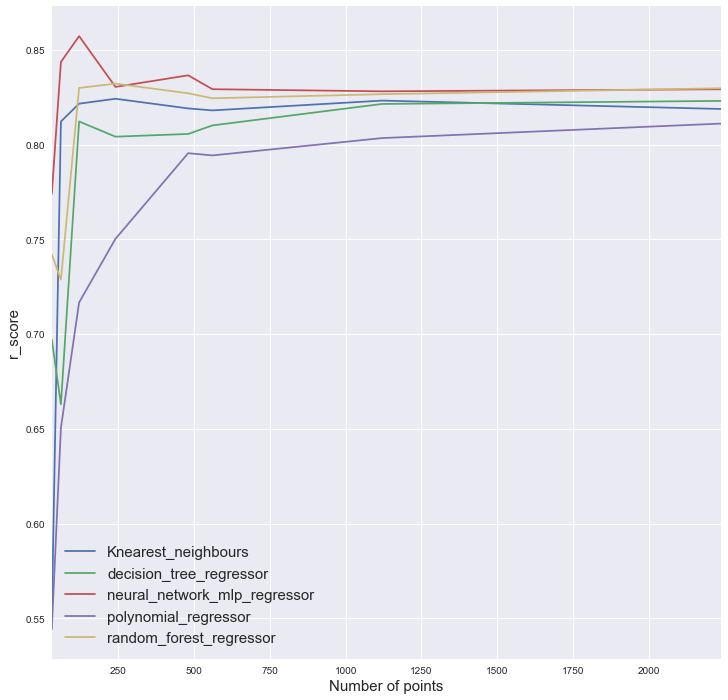

In [687]:
fig, ax = plt.subplots(figsize=(12,12))
for model in df_impact.columns:
    df_impact.plot(ax=ax,y=model,kind="line",label=model)

ax.set_xlabel("Number of points", fontsize=15)
ax.set_ylabel("r_score", fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

ax.figure.savefig("../../reports/pictures/trainingset_impact.png")

## Use the national vector

In [518]:
df_ptg2=df_daily_weather_national.join(df_daily_energy_consumption,how='inner')[["outdoor_temperature","outdoor_humidity","wind_speed","energy","month","weekday"]]
df_ptg2.head()

,outdoor_temperature,outdoor_humidity,wind_speed,energy,month,weekday
day,,,,,,
2008-01-01,2.646324,87.222476,9.126380,1465179.0,1,1
2008-01-02,1.560249,82.536580,16.950993,1737852.0,1,2
2008-01-03,3.802147,84.724081,17.384831,1792039.0,1,3
2008-01-04,6.731422,85.865923,16.420075,1713511.5,1,4
2008-01-05,8.387348,87.866949,18.261896,1526082.0,1,5


In [679]:
df_split=df_ptg2.copy()
for param in ['outdoor_temperature','outdoor_humidity','wind_speed','month','weekday']:
    df_split[param]=df_split.apply(lambda row: (row[param]-df_split[param].mean())/(df_split[param].max()-df_split[param].min()),axis=1)
print(df_split.head())


# # # Make linear regression
# X_train, X_test, y_train, y_test = train_test_split(df[['outdoor_temperature','weekday','month']],df["energy"],test_size=0.2,random_state=42)
# print("Training samples",len(X_train))
# print("Test samples",len(X_test))


X_train, X_test, y_train, y_test = train_test_split(np.array(df_split["outdoor_temperature"]),np.array(df_split["energy"]),test_size=0.2,random_state=42)

print("Number of elements for the training set: {} samples".format(len(X_train)))
print("Number of elements for the testing set: {} samples".format(len(X_test)))

            outdoor_temperature  outdoor_humidity  wind_speed     energy  \
day                                                                        
2008-01-01            -0.300381          0.268657   -0.142103  1465179.0   
2008-01-02            -0.334163          0.171280    0.142901  1737852.0   
2008-01-03            -0.264430          0.216738    0.158703  1792039.0   
2008-01-04            -0.173316          0.240467    0.123563  1713511.5   
2008-01-05            -0.121809          0.282050    0.190650  1526082.0   

               month   weekday  
day                             
2008-01-01 -0.502085 -0.333162  
2008-01-02 -0.502085 -0.166496  
2008-01-03 -0.502085  0.000171  
2008-01-04 -0.502085  0.166838  
2008-01-05 -0.502085  0.333504  
Number of elements for the training set: 2337 samples
Number of elements for the testing set: 585 samples


### PTG model

In [680]:
result_ptg=get_bestptgmodel(X_train, X_test, y_train, y_test,kf)
result_ptg

0.816177858388 95422.1020139
Best model: 0.816177858388 0.014036417007446289
0.840908874828 83206.7617848
Best model: 0.840908874828 0.013034820556640625
0.828772009198 92902.2337296
0.844222297338 90331.5662582
Best model: 0.844222297338 0.01704573631286621
0.850288293658 86079.5474036
Best model: 0.850288293658 0.019051551818847656
0.8016614188 97287.8960968
0.795457190887 96942.3666251
0.836096475357 85865.6442957
0.830655461297 91403.7301331
0.835908703339 93984.9788852
Final results: 0.827963281654 91718.7070291 0.019051551818847656


((-1622498.0411481452, 1262176.5081225571, 0.10062127440661144),
 0.82796328165368971,
 91718.707029075667,
 0.019051551818847656)

### Polynomial regressor

In [682]:
result=get_bestpolynomialmodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,15)
result

0.788994404627 100141.900334
Best model: 0.788994404627 0.0029816627502441406
0.825534660687 85826.0400635
Best model: 0.825534660687 0.002005338668823242
0.819033070021 93450.0760431
0.82242461481 93535.6751521
0.834198097749 89431.5379277
Best model: 0.834198097749 0.003008127212524414
0.801432996343 97262.1962759
0.778636790962 101083.172473
0.828794945108 86095.0382198
0.80543575475 96666.7913727
0.814985968759 97757.4217314
Final results: 0.811449767189 94487.0087506 0.003008127212524414


(Pipeline(memory=None,
      steps=[('polynomialfeatures', PolynomialFeatures(degree=15, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001))]),
 0.81144976718868955,
 94487.008750610214,
 0.003008127212524414)

### Random forest model

In [683]:
result=get_bestrandomforestmodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,4)
result

Final results: 0.831853000582 91109.498063 0.017075300216674805


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
 0.83185300058195044,
 91109.498062999643,
 0.017075300216674805)

### Decision tree model

In [524]:
result=get_bestdecisiontreemodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,4)
result

Final results: 0.83138826702 90919.2216968 0.0065500736236572266


(DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
 0.83138826701995072,
 90919.221696790948,
 0.0065500736236572266)

### K-nearest neighbours

In [526]:
result=get_bestknearestmodel(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,[19,'uniform'])
result

(KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform'),
 0.82327380045936205,
 92733.457399910025,
 0.005013704299926758)

### Neural network mlp regressor

In [527]:
result=get_bestmlp(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test,kf,[256,"relu","lbfgs"])
result

Final results: 0.829087951299 91421.9768832 1.2042014598846436


(MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=256, learning_rate='constant',
        learning_rate_init=0.001, max_iter=200, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
        solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
        warm_start=False),
 0.82908795129853463,
 91421.976883233234,
 1.2042014598846436)

### Test more features in the models

In [695]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df_split[["outdoor_temperature","month","weekday"]]),np.array(df_split["energy"]),test_size=0.2,random_state=42)

print("Number of elements for the training set: {} samples".format(len(X_train)))
print("Number of elements for the testing set: {} samples".format(len(X_test)))

Number of elements for the training set: 2337 samples
Number of elements for the testing set: 585 samples


In [696]:
results_poly=get_bestpolynomialmodel(X_train, X_test, y_train, y_test,kf,15)

Best model: 0.926258272138 0.12832307815551758
Best model: 0.93661995878 0.09625625610351562
Final results: 0.920863149665 57042.920472 0.09625625610351562


In [697]:
result=get_bestrandomforestmodel(X_train, X_test, y_train, y_test,kf,4)

Final results: 0.910517527179 59200.8138842 0.01604628562927246


In [537]:
result=get_bestdecisiontreemodel(X_train, X_test, y_train, y_test,kf,4)

Final results: 0.89857357363 62502.7937656 0.003007650375366211


In [538]:
result=get_bestknearestmodel(X_train, X_test, y_train, y_test,kf,[19,'uniform'])

Final results: 0.931988462958 49312.9089519 0.0030083656311035156


In [699]:
result=get_bestmlp(X_train, X_test, y_train, y_test,kf,[256,"relu","lbfgs"])

Final results: 0.903747743813 66186.0389385 1.847914218902588


## Half hourly forecast

### Prepare the data for the analysis

In [700]:
df_30m=df_30m_nationalconsumption_definitive.copy()
df_30m=df_30m.drop(["day","consumption"],axis=1)
df_30m=df_30m.reset_index()
df_30m["halfhour"]=df_30m.apply(lambda row: int(row["halfhour"]),axis=1)
df_30m.head()

,tstp,quality,energy,month,weekday,halfhour
0,2008-07-06 10:00:00,Definitive,22243.0,7,6,10
1,2008-07-06 11:00:00,Definitive,23135.0,7,6,11
2,2008-07-06 11:30:00,Definitive,22400.5,7,6,12
3,2008-07-06 13:00:00,Definitive,20959.5,7,6,13
4,2008-07-06 14:30:00,Definitive,20067.5,7,6,15


In [701]:
df_weather_national=pd.read_csv("../../data/weathernational_data.csv.gz")
df_weather_national["tstp"]=pd.to_datetime(df_weather_national["tstp"])
# df_weather_national=df_weather_national.set_index(["tstp"])
df_weather_national.head()

,tstp,outdoor_humidity,outdoor_temperature,wind_speed
0,2007-06-06 14:30:00,62.555688,22.965797,17.073516
1,2007-06-06 15:00:00,63.815123,22.869189,17.166643
2,2007-06-06 15:30:00,64.946597,22.470817,17.159937
3,2007-06-06 16:00:00,67.336973,22.186515,16.841663
4,2007-06-06 16:30:00,67.237105,22.166204,16.926711


In [702]:
df_halfhourly=df_30m.merge(df_weather_national,on="tstp",how='inner')
df_halfhourly.describe()

,energy,month,weekday,halfhour,outdoor_humidity,outdoor_temperature,wind_speed
count,140254.000000,140254.000000,140254.000000,140254.000000,140254.000000,140254.000000,140254.000000
mean,27642.826372,6.522053,2.998973,11.999950,74.293132,12.303254,13.027899
std,6084.637072,3.448683,1.999422,6.939978,13.492496,6.817193,4.761834
min,14738.500000,1.000000,0.000000,0.000000,19.814440,-9.091748,4.080585
25%,23004.500000,4.000000,1.000000,6.000000,66.237474,7.238466,9.452496
50%,26864.500000,7.000000,3.000000,12.000000,78.101832,12.181394,12.216043
75%,31797.375000,10.000000,5.000000,18.000000,84.974964,17.282491,15.805559
max,50933.000000,12.000000,6.000000,24.000000,94.159421,33.940691,40.214475


In [703]:
# Normalisation of the data
df_split=df_halfhourly.copy()
for param in ['outdoor_temperature','outdoor_humidity','wind_speed','month','weekday','halfhour']:
    print(param)
    mean_p=df_split[param].mean()
    max_p=df_split[param].max()
    min_p=df_split[param].min()
    df_split[param]=df_split.apply(lambda row: (row[param]-mean_p)/(max_p-min_p),axis=1)
print(df_split.head())

outdoor_temperature
outdoor_humidity
wind_speed
month
weekday
halfhour
                 tstp     quality   energy    month   weekday  halfhour  \
0 2008-07-06 10:00:00  Definitive  22243.0  0.04345  0.500171 -0.083331   
1 2008-07-06 11:00:00  Definitive  23135.0  0.04345  0.500171 -0.041665   
2 2008-07-06 11:30:00  Definitive  22400.5  0.04345  0.500171  0.000002   
3 2008-07-06 13:00:00  Definitive  20959.5  0.04345  0.500171  0.041669   
4 2008-07-06 14:30:00  Definitive  20067.5  0.04345  0.500171  0.125002   

   outdoor_humidity  outdoor_temperature  wind_speed  
0         -0.032344             0.148047    0.133004  
1         -0.076276             0.163001    0.201757  
2         -0.105859             0.169944    0.220548  
3         -0.152848             0.187699    0.249625  
4         -0.168669             0.189454    0.270396  


In [704]:
# df_split=df_split.replace([np.inf, -np.inf], np.nan)
# df_test_quality=pd.isnull(df_split)
# for param in ["outdoor_temperature",'month','weekday','halfhour',"energy"]:
#     print(param)
#     print(df_test_quality[df_test_quality[param]==True])

In [705]:
# df_split=df_split.dropna()
X_train, X_test, y_train, y_test = train_test_split(np.array(df_split[["outdoor_temperature",'month','weekday','halfhour']]),np.array(df_split["energy"]),test_size=0.2,random_state=42)

print("Number of elements for the training set: {} samples".format(len(X_train)))
print("Number of elements for the testing set: {} samples".format(len(X_test)))

Number of elements for the training set: 112203 samples
Number of elements for the testing set: 28051 samples


### Benchmark model (ARIMA model)

In [711]:
series = df_30m_nationalconsumption_definitive["energy"]
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
tic=time.time()
model = ARIMA(history, order=(5,1,0))
toc=time.time()-tic
model_fit = model.fit(disp=0)
for t in range(len(test)):
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

print(r2_score(test, predictions),toc)

-0.661724091996 0.015029668807983398


### Polynomial regressor

In [707]:
list_results=[]
r2score_ref=-1*np.inf
for degree in range(0,16):
    print(r2score_ref)
    print("DEGREE:",degree)
    results_poly=get_bestpolynomialmodel(X_train, X_test, y_train, y_test,kf,degree)
    list_results.append(["PR:{}".format(degree),results_poly[1],results_poly[2],results_poly[3]])
    if results_poly[1]>r2score_ref:
        print(degree)
        r2score_ref=results_poly[1]
        ref_model=results_poly
print('-------------FINAL_BM-------------',ref_model)
df_resultspoly=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultspoly.head())

-inf
DEGREE: 0
-5.89940944207e-06 4950.55818585
Best model: -5.89940944207e-06 0.006015777587890625
-7.05939470436e-06 4915.8630473
-3.12812064651e-05 4902.21064494
-0.000167931870753 4950.14218262
-9.59514558883e-05 5014.15876799
-2.38120039686e-07 4980.81426728
Best model: -2.38120039686e-07 0.005013942718505859
-3.08273305516e-05 4942.57676512
-1.51789927565e-05 4887.83694904
-3.83606115761e-08 5001.57271369
Best model: -3.83606115761e-08 0.005013227462768555
-1.06086871194e-05 4918.53440367
Final results: -9.60602781852e-06 4925.64537527 0.005013227462768555
0
-9.60602781852e-06
DEGREE: 1
0.554176311618 3325.30196765
Best model: 0.554176311618 0.026068449020385742
0.55608925416 3323.79667045
Best model: 0.55608925416 0.020032644271850586
0.559524731024 3283.07462504
Best model: 0.559524731024 0.019049882888793945
0.560299808876 3324.28725339
Best model: 0.560299808876 0.019050121307373047
0.572369373705 3302.3846449
Best model: 0.572369373705 0.01704549789428711
0.57323993223 3282.

KeyboardInterrupt: 

### Random Forest regressor

In [635]:
list_results=[]
r2score_ref=-1*np.inf
for max_depth in range(2,15):
    print("MAX_DEPTH:",max_depth)
    results_randomforest=get_bestrandomforestmodel_update(X_train, X_test, y_train, y_test,kf,max_depth)
    list_results.append(["RF:{}".format(max_depth),results_randomforest[1],results_randomforest[2],results_randomforest[3]])
    if results_randomforest[1]>r2score_ref:
        print(degree)
        r2score_ref=results_randomforest[1]
        ref_model=results_randomforest
print('-------------FINAL_BM-------------',ref_model)    
df_resultsrandomforest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsrandomforest.head())

MAX_DEPTH: 2
Final results: 0.600367070796 3029.01090727 0.3343930244445801
11
MAX_DEPTH: 3
Final results: 0.731493538921 2515.24571153 0.4993443489074707
11
MAX_DEPTH: 4
Final results: 0.794866107292 2154.08285003 0.6106851100921631
11
MAX_DEPTH: 5
Final results: 0.845736857603 1831.66587072 0.7268998622894287
11
MAX_DEPTH: 6
Final results: 0.878225923049 1608.24575723 0.8176429271697998
11
MAX_DEPTH: 7
Final results: 0.900089892019 1442.9073155 0.9295446872711182
11
MAX_DEPTH: 8
Final results: 0.914494684246 1330.01307059 1.0469086170196533
11
MAX_DEPTH: 9
Final results: 0.925418427347 1228.49683911 1.1566407680511475
11
MAX_DEPTH: 10
Final results: 0.934052843044 1139.08781655 1.2538950443267822
11
MAX_DEPTH: 11
Final results: 0.939068605735 1085.47566023 1.3240673542022705
11
MAX_DEPTH: 12
Final results: 0.942277849351 1050.48036127 1.6566965579986572
11
MAX_DEPTH: 13
Final results: 0.943689834843 1032.56621464 1.3500902652740479
11
MAX_DEPTH: 14
Final results: 0.944537899125 1021.

### Decision tree regressor

In [637]:
list_results=[]
r2score_ref=-1*np.inf
for max_depth in range(2,16):
    print("MAX_DEPTH:",max_depth)
    results_tdecisiontree=get_bestdecisiontreemodel_update(X_train, X_test, y_train, y_test,kf,max_depth)
    list_results.append(["DT:{}".format(max_depth),results_tdecisiontree[1],results_tdecisiontree[2],results_tdecisiontree[3]])
    if results_tdecisiontree[1]>r2score_ref:
        r2score_ref=results_tdecisiontree[1]
        ref_model=results_tdecisiontree
print('-------------FINAL_BM-------------',ref_model)        
df_resultsdecisiontree=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsdecisiontree.head())

MAX_DEPTH: 2
Final results: 0.580700505976 3093.63216581 0.04659104347229004
MAX_DEPTH: 3
Final results: 0.698796464385 2695.65127892 0.07121729850769043
MAX_DEPTH: 4
Final results: 0.778913337875 2234.51729569 0.09124207496643066
MAX_DEPTH: 5
Final results: 0.833210010987 1903.99071332 0.12541842460632324
MAX_DEPTH: 6
Final results: 0.867792405362 1678.64505023 0.11489295959472656
MAX_DEPTH: 7
Final results: 0.890353648725 1511.63016387 0.15392279624938965
MAX_DEPTH: 8
Final results: 0.907365725064 1386.49769496 0.1629343032836914
MAX_DEPTH: 9
Final results: 0.918747889363 1284.95545359 0.1629328727722168
MAX_DEPTH: 10
Final results: 0.927233044114 1199.84047021 0.17396163940429688
MAX_DEPTH: 11
Final results: 0.93305511297 1139.37684412 0.18799877166748047
MAX_DEPTH: 12
Final results: 0.93554768281 1109.47449189 0.2215867042541504
MAX_DEPTH: 13
Final results: 0.936028941114 1094.31753395 0.21707701683044434
MAX_DEPTH: 14
Final results: 0.935064820438 1089.96337741 0.22309350967407227

### K-nearest neighbours

In [639]:
list_results=[]
r2score_ref=-1*np.inf
for neighbors in range(1,30):
    print("NUMBER OF NEIGHBORS:",neighbors)
    for weights in ['uniform','distance']:
        print("WEIGHTS",weights)
        results_knearest=get_bestknearestmodel_update(X_train, X_test, y_train, y_test,kf,[neighbors,weights])
        list_results.append(["KNN:{}/{}".format(neighbors,weights),results_knearest[1],results_knearest[2],results_knearest[3]])
        if results_knearest[1]>r2score_ref:
            r2score_ref=results_knearest[1]
            ref_model=results_knearest
print('-------------FINAL_BM-------------',ref_model) 
df_resultsknearest=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsknearest.head())

NUMBER OF NEIGHBORS: 1
WEIGHTS uniform
Final results: 0.916930071553 1212.37784749 0.2541790008544922
WEIGHTS distance
Final results: 0.916930071553 1212.37784749 0.2672102451324463
NUMBER OF NEIGHBORS: 2
WEIGHTS uniform
Final results: 0.934352260367 1109.66009233 0.2687833309173584
WEIGHTS distance
Final results: 0.932196363882 1112.83502239 0.2812681198120117
NUMBER OF NEIGHBORS: 3
WEIGHTS uniform
Final results: 0.939154853536 1081.38273739 0.25872278213500977
WEIGHTS distance
Final results: 0.93713043466 1080.765771 0.26770973205566406
NUMBER OF NEIGHBORS: 4
WEIGHTS uniform
Final results: 0.94159513805 1062.55710581 0.26219701766967773
WEIGHTS distance
Final results: 0.939518284281 1064.01473621 0.2651975154876709
NUMBER OF NEIGHBORS: 5
WEIGHTS uniform
Final results: 0.94294990268 1050.95005882 0.22108697891235352
WEIGHTS distance
Final results: 0.940834949975 1053.85723434 0.2922804355621338
NUMBER OF NEIGHBORS: 6
WEIGHTS uniform
Final results: 0.94374254291 1044.29129978 0.2652361

### Neural network MLP regressor

In [641]:
list_results=[]
r2score_ref=-1*np.inf
for hidden_layers in [2,4,8,16,32,64,128,256]:
    for activation in ["identity","logistic","tanh","relu"]:
        for solver in ["lbfgs","adam"]:
            print(hidden_layers,activation,solver)
            results_mlp=get_bestmlp_update(X_train, X_test, y_train, y_test,kf,[hidden_layers,activation,solver])
            list_results.append(["NN_MLP:{}/{}/{}".format(hidden_layers,activation,solver),results_mlp[1],results_mlp[2],results_mlp[3]])
            if results_mlp[1]>r2score_ref:
                r2score_ref=results_mlp[1]
                ref_model=results_mlp
print('-------------FINAL_BM-------------',ref_model) 
df_resultsmlp=pd.DataFrame(list_results,columns=["models","r2_score","mean_abs_error","execution_time"])
print(df_resultsmlp.head())


2 identity lbfgs
Final results: 0.560085399298 3307.37201381 0.13385677337646484
2 identity adam


C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Final results: -0.390604100803 6058.68428724 19.873370885849
2 logistic lbfgs
Final results: -9.60602270661e-06 4925.64537468 0.11831450462341309
2 logistic adam
Final results: -20.2235245682 27323.5708574 22.549622535705566
2 tanh lbfgs
Final results: -9.60602172739e-06 4925.64537457 0.10277175903320312
2 tanh adam
Final results: -20.2229967148 27323.2142694 22.921502351760864
2 relu lbfgs
Final results: 0.560085418885 3307.37200958 0.13385391235351562
2 relu adam
Final results: -0.388870985912 6050.49202158 21.62906837463379
4 identity lbfgs
Final results: 0.560085379208 3307.37207201 0.1664423942565918
4 identity adam
Final results: 0.560037323864 3307.34125047 20.243532180786133
4 logistic lbfgs
Final results: -9.60602317512e-06 4925.64537473 0.14488458633422852
4 logistic adam
Final results: -19.9242160815 27120.622506 22.369072675704956
4 tanh lbfgs
Final results: -9.60602248923e-06 4925.64537466 0.14438343048095703
4 tanh adam
Final results: -19.9253019021 27121.3614994 24.45466

C:\Users\daign\Anaconda3\envs\dev_dataanalytics_36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Final results: 0.560066545771 3307.33785444 16.581605672836304
-------------FINAL_BM------------- (MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=256, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False), 0.9303951493936744, 1182.5028819368936, 156.28945899009705)
                    models   r2_score  mean_abs_error  execution_time
0  NN_MLP:2/identity/lbfgs   0.560085     3307.372014        0.133857
1   NN_MLP:2/identity/adam  -0.390604     6058.684287       19.873371
2  NN_MLP:2/logistic/lbfgs  -0.000010     4925.645375        0.118315
3   NN_MLP:2/logistic/adam -20.223525    27323.570857       22.549623
4      NN_MLP:2/tanh/lbfgs  -0.000010     4925.645375     

## Free form visualisation

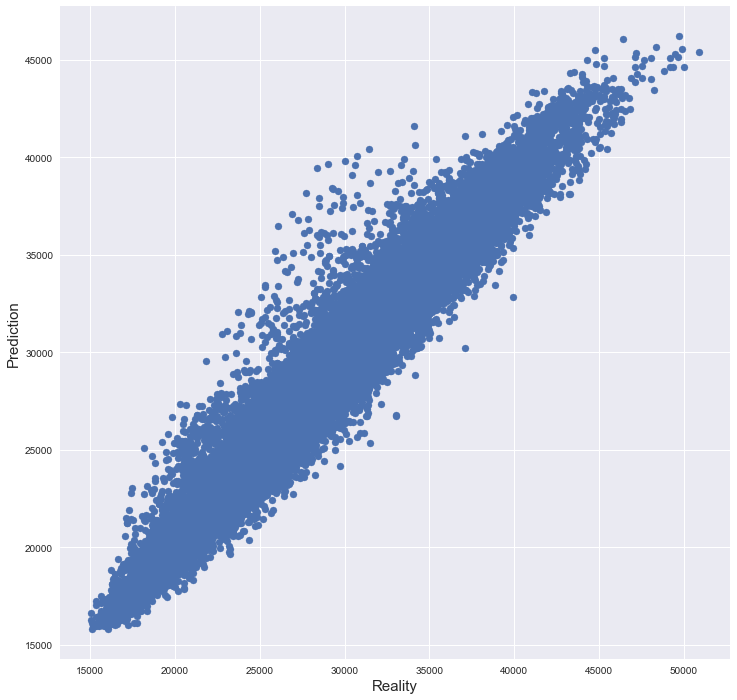

In [717]:
fig, ax = plt.subplots(figsize=(12,12))

model=KNeighborsRegressor(28, weights="uniform")
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

ax.scatter(x=y_test,y=y_pred)

ax.set_xlabel("Reality", fontsize=15)
ax.set_ylabel("Prediction", fontsize=15)
# plt.legend(prop={'size': 15})
plt.show()

ax.figure.savefig("../../reports/pictures/freeform_vis.png")